# 📊 Full Database Embeddings Analysis & Visualization

This notebook performs comprehensive analysis of the expanded IFC publication database using embeddings and creates various visualizations to understand the research landscape.

## What This Notebook Does:
- Loads the complete expanded database (IFC + PubMed articles)
- Generates embeddings for all publications using Google Gemini
- Creates 2D/3D visualizations using t-SNE and UMAP
- Performs clustering analysis
- Builds similarity networks
- Compares IFC vs PubMed article distributions
- Identifies research themes and trends

## 1. Setup and Data Loading

In [2]:
# Core imports
import json
import pandas as pd
import numpy as np
from datetime import datetime
import os
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML and embeddings
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import umap

# Google Gemini for embeddings
%pip install google-generativeai
import google.generativeai as genai
from google.generativeai import types
from tqdm.auto import tqdm

# Network analysis
import networkx as nx

print("✅ All imports successful!")

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ All imports successful!
✅ All imports successful!


In [3]:
# Configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
tqdm.pandas()

# Set random seed for reproducibility
np.random.seed(42)

print("📊 Visualization settings configured")

📊 Visualization settings configured


In [4]:
# Load the expanded database
database_path = 'data/processed/expanded_ifc_publications.json'

try:
    with open(database_path, 'r', encoding='utf-8') as f:
        database_data = json.load(f)
    
    publications = database_data['publications']
    metadata = database_data['metadata']
    
    print(f"📚 Loaded {len(publications)} publications from expanded database")
    print(f"📊 Database metadata:")
    print(f"   • Total publications: {metadata['total_publications']}")
    print(f"   • Last updated: {metadata['last_updated']}")
    print(f"   • Original IFC articles: {metadata['sources']['original_ifc_scraping']}")
    print(f"   • New PubMed articles: {metadata['sources']['pubmed_filtered_search']}")
    print(f"   • New articles added: {metadata['new_articles_added']}")
    
except FileNotFoundError:
    print("❌ Expanded database not found. Please run the database expansion notebook first.")
    print("Expected file: data/processed/expanded_ifc_publications.json")
    raise

📚 Loaded 852 publications from expanded database
📊 Database metadata:
   • Total publications: 852
   • Last updated: 2025-09-22T18:57:32.619101
   • Original IFC articles: 0
   • New PubMed articles: 852
   • New articles added: 852


In [5]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(publications)

# Add source column to distinguish IFC vs PubMed articles
df['source_type'] = df['metadata'].apply(
    lambda x: 'PubMed' if x.get('source') == 'PubMed_filtered_search' else 'IFC'
)

# Create text for embedding (title + abstract)
df['embedding_text'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')
df['embedding_text'] = df['embedding_text'].str.strip()

# Basic statistics
print(f"📊 Dataset Overview:")
print(f"   • Total articles: {len(df)}")
print(f"   • IFC articles: {len(df[df['source_type'] == 'IFC'])}")
print(f"   • PubMed articles: {len(df[df['source_type'] == 'PubMed'])}")
print(f"   • Articles with abstracts: {len(df[df['abstract'].notna()])}")
print(f"   • Year range: {df['year'].min()} - {df['year'].max()}")

df.head()

📊 Dataset Overview:
   • Total articles: 852
   • IFC articles: 0
   • PubMed articles: 852
   • Articles with abstracts: 852
   • Year range: 1992 - 2025


title  \
0  Comprehensive Biomarker Assessment of Pesticid...   
1  A National Study of Somatotypes in Mexican Ath...   
2  Growth hormone reduces retinal inflammation an...   
3       Multivalvular infective endocarditis due to    
4  Acute liver injury as a manifestation of granu...   

                                             authors  \
0  Ruiz-Arias, Miguel Alfonso; Bernal-Hernández, ...   
1  Martínez-Mireles, Ximena; Lagunes-Carrasco, Jo...   
2  Balderas-Márquez, Jerusa E; Epardo, David; Siq...   
3  Zúñiga-Espinosa, José Emmanuel; Peralta-Amaro,...   
4  Martinez-Marquez, Melissa N; Feria-Agudelo, Sa...   

                                            journal  year  \
0                            Journal of xenobiotics  2025   
1  Journal of functional morphology and kinesiology  2025   
2                Frontiers in cellular neuroscience  2025   
3                       Oxford medical case reports  2025   
4                       Oxford medical case reports  2025   

                          doi pubmed_id ifc_url  \
0         10.3390/jox15050141  40981352    None   
1        10.3390/jfmk10030329  40981028    None   
2  10.3389/fncel.2025.1636399  40980564    None   
3        10.1093/omcr/omaf156  40979811    None   
4        10.1093/omcr/omaf160  40979809    None   

                                            abstract keywords  \
0  Children are more vulnerable to the adverse ef...     None   
1                                                        None   
2  This study investigates the neuroprotective ro...     None   
3  Multivalvular infective endocarditis (MIE) is ...     None   
4  Granulomatous hepatitis is a rare clinical ent...     None   

                                      embedding_text  \
0  Comprehensive Biomarker Assessment of Pesticid...   
1  A National Study of Somatotypes in Mexican Ath...   
2  Growth hormone reduces retinal inflammation an...   
3  Multivalvular infective endocarditis due to  M...   
4  Acute liver injury as a manifestation of granu...   

                                            metadata source_type  
0  {'source': 'PubMed_filtered_search', 'has_full...      PubMed  
1  {'source': 'PubMed_filtered_search', 'has_full...      PubMed  
2  {'source': 'PubMed_filtered_search', 'has_full...      PubMed  
3  {'source': 'PubMed_filtered_search', 'has_full...      PubMed  
4  {'source': 'PubMed_filtered_search', 'has_full...      PubMed

## 2. Google Gemini Setup for Embeddings

In [5]:
# Setup Gemini client
# Make sure you have GEMINI_API_KEY in your environment
import os

try:
    api_key = os.getenv('GEMINI_API_KEY')
    if not api_key:
        print("⚠️  GEMINI_API_KEY not found in environment variables.")
        print("Please set it with: export GEMINI_API_KEY='your-api-key'")
        # For testing purposes, you can uncomment and set it directly:
        # api_key = 'your-api-key-here'
        raise ValueError("API key required")
    
    # Configure the API key
    genai.configure(api_key=api_key)
    print("✅ Gemini API configured successfully")
    
    # List available embedding models
    print("\n📋 Available embedding models:")
    for m in genai.list_models():
        if 'embedContent' in m.supported_generation_methods:
            print(f"   • {m.name}")
            
except Exception as e:
    print(f"❌ Error setting up Gemini API: {e}")
    print("\n💡 Alternative: You can load pre-computed embeddings if available")

✅ Gemini API configured successfully

📋 Available embedding models:


E0000 00:00:1758671531.318831  304726 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


   • models/embedding-001
   • models/text-embedding-004
   • models/gemini-embedding-exp-03-07
   • models/gemini-embedding-exp
   • models/gemini-embedding-001


In [6]:
# Select embedding model
MODEL_ID = "models/gemini-embedding-001"
print(f"🎯 Using embedding model: {MODEL_ID}")

🎯 Using embedding model: models/gemini-embedding-001


## 3. Generate Embeddings

In [4]:
import time
from datetime import datetime, timedelta

def make_embed_text_fn(model_id, rate_limit_rpm=90):
    """Create rate-limited embedding function for batch processing"""
    
    # Rate limiting setup
    min_interval = 60.0 / rate_limit_rpm  # Minimum seconds between requests
    last_request_time = [0]  # Use list to allow modification in nested function
    
    def embed_fn(text: str) -> list[float]:
        """Generate embedding for a single text with rate limiting"""
        try:
            # Rate limiting: ensure we don't exceed RPM
            current_time = time.time()
            time_since_last = current_time - last_request_time[0]
            
            if time_since_last < min_interval:
                sleep_time = min_interval - time_since_last
                time.sleep(sleep_time)
            
            # Make the API request
            result = genai.embed_content(
                model=model_id,
                content=text,
                task_type="clustering"
            )
            
            last_request_time[0] = time.time()
            return np.array(result['embedding'])
            
        except Exception as e:
            if "429" in str(e) or "quota" in str(e).lower():
                print(f"⏰ Rate limit hit, waiting 60 seconds...")
                time.sleep(60)
                # Retry once after rate limit
                try:
                    result = genai.embed_content(
                        model=model_id,
                        content=text,
                        task_type="clustering"
                    )
                    last_request_time[0] = time.time()
                    return np.array(result['embedding'])
                except Exception as e2:
                    print(f"Error after retry: {str(e2)[:100]}...")
                    return np.zeros(768)  # Fallback
            else:
                print(f"Error embedding text: {str(e)[:100]}...")
                return np.zeros(768)  # Fallback
    
    return embed_fn

# Create rate-limited embedding function (90 RPM to be safe)
embed_fn = make_embed_text_fn(MODEL_ID, rate_limit_rpm=90)
print("🔧 Rate-limited embedding function created (90 RPM)")
print("⏰ This will process ~90 articles per minute with automatic rate limiting")

NameError: name 'MODEL_ID' is not defined

In [13]:
# Test the embedding function
test_text = "This is a test publication about cellular physiology and neuroscience research."
test_embedding = embed_fn(test_text)

print(f"✅ Test embedding successful!")
print(f"📊 Embedding shape: {test_embedding.shape}")
print(f"🔢 First 5 values: {test_embedding[:5]}")
print(f"📈 Embedding norm: {np.linalg.norm(test_embedding):.4f}")

E0000 00:00:1758673436.095721  304726 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


✅ Test embedding successful!
📊 Embedding shape: (3072,)
🔢 First 5 values: [-0.01221536  0.02384436 -0.00953624 -0.04706245  0.00687762]
📈 Embedding norm: 1.0000


Rate Limiting:

- Tracks and respects both per-minute (RPM) and per-day (RPD) limits
- Uses conservative limits (60 RPM, 900 RPD) to provide safety buffer

Robust Error Handling:

- Implements exponential backoff for retries (wait longer after each failure)
- Multiple retry attempts (5) instead of just one

Checkpointing System:

Saves progress every 10 articles

- Creates checkpoint file with processed IDs and quota tracking
- Can resume from exact position after interruption

Smart Quota Management:

- Detects new days to reset daily quota counter
- Calculates how many more requests can be made today
- Stops gracefully when approaching daily limit

Better Monitoring:

- Shows detailed statistics about processing
- Reports on quota usage
- Provides accurate ETA based on processing rate

In [14]:
print("🚀 IMPROVED EMBEDDING GENERATION WITH ADVANCED RATE LIMITING")
print("=" * 70)

import time
import json
import os
import numpy as np
from datetime import datetime
from tqdm.auto import tqdm

def generate_embeddings_with_smart_rate_limiting(df, model_id, output_dir='data/processed'):
    """
    Generate embeddings with comprehensive rate limiting and checkpointing
    
    Features:
    - Respects both per-minute and daily limits
    - Incremental saves/checkpoints
    - Smart retry with exponential backoff
    - Resume from previous partial runs
    """
    embeddings_file = f'{output_dir}/publication_embeddings.npy'
    embeddings_meta_file = f'{output_dir}/publication_embeddings_meta.json'
    checkpoint_file = f'{output_dir}/embedding_checkpoint.json'
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Filter texts
    df_embed = df[df['embedding_text'].str.len() > 10].copy()
    total_to_process = len(df_embed)
    
    # Check for checkpoint to resume
    processed_ids = []
    embeddings_list = []
    daily_request_count = 0
    last_saved_timestamp = None
    start_idx = 0
    
    if os.path.exists(checkpoint_file):
        print("📋 Found checkpoint, resuming from previous run...")
        with open(checkpoint_file, 'r') as f:
            checkpoint = json.load(f)
            
        processed_ids = checkpoint.get('processed_ids', [])
        daily_request_count = checkpoint.get('daily_request_count', 0)
        last_saved_timestamp = checkpoint.get('last_saved_timestamp')
        start_idx = len(processed_ids)
        
        # Load existing embeddings
        if os.path.exists(embeddings_file):
            embeddings_list = list(np.load(embeddings_file))
            print(f"✅ Loaded {len(embeddings_list)} existing embeddings")
        
        # Check if it's a new day to reset the counter
        if last_saved_timestamp:
            last_date = datetime.fromisoformat(last_saved_timestamp).date()
            current_date = datetime.now().date()
            if current_date > last_date:
                print(f"📆 New day detected! Resetting daily quota counter.")
                daily_request_count = 0
    
    # Rate limiting parameters
    RPM_LIMIT = 60  # Requests per minute (conservative from 100 to avoid issues)
    RPD_LIMIT = 900  # Requests per day (conservative from 1000 to have buffer)
    min_interval = 60.0 / RPM_LIMIT
    last_request_time = time.time()
    
    # Constants
    CHECKPOINT_FREQUENCY = 10  # Save checkpoint every N articles
    MAX_RETRIES = 5
    INITIAL_RETRY_DELAY = 10  # seconds
    
    print(f"\n📊 Processing Statistics:")
    print(f"   • Total articles to process: {total_to_process}")
    print(f"   • Articles already processed: {start_idx}")
    print(f"   • Articles remaining: {total_to_process - start_idx}")
    print(f"   • Daily API requests used: {daily_request_count}/{RPD_LIMIT}")
    print(f"   • Rate limits: {RPM_LIMIT} RPM / {RPD_LIMIT} RPD\n")
    
    # Check if we have enough daily quota remaining
    if RPD_LIMIT - daily_request_count <= 0:
        print("⚠️ DAILY QUOTA EXHAUSTED - Cannot process more articles today!")
        print("   → Consider running again tomorrow when quota resets")
        print("   → Returning already processed embeddings")
        return np.array(embeddings_list), df_embed.iloc[:len(embeddings_list)]
    
    # Remaining articles to process with daily limit consideration
    max_articles_today = min(total_to_process - start_idx, RPD_LIMIT - daily_request_count)
    print(f"🔄 Will process {max_articles_today} articles in this run (limited by remaining daily quota)")
    
    # Skip already processed
    items_to_process = list(df_embed['embedding_text'].items())[start_idx:start_idx + max_articles_today]
    
    # Process remaining articles
    failed_indices = []
    start_time = time.time()
    
    print(f"\n🚀 Starting embedding generation...")
    print(f"📊 Progress will be shown every {CHECKPOINT_FREQUENCY} articles")
    
    for i, (idx, text) in enumerate(tqdm(items_to_process, desc="Generating embeddings")):
        current_idx = start_idx + i
        
        # Progress updates
        if i > 0 and i % CHECKPOINT_FREQUENCY == 0:
            elapsed = time.time() - start_time
            rate = i / elapsed * 60  # Articles per minute
            eta = (max_articles_today - i) / (rate / 60) if rate > 0 else 0
            print(f"📈 Processed {i}/{max_articles_today} | Rate: {rate:.1f}/min | ETA: {eta/60:.1f}min")
            
            # Save checkpoint at regular intervals
            checkpoint = {
                'processed_ids': processed_ids,
                'daily_request_count': daily_request_count,
                'last_saved_timestamp': datetime.now().isoformat()
            }
            with open(checkpoint_file, 'w') as f:
                json.dump(checkpoint, f)
            
            # Save embeddings incrementally
            np.save(embeddings_file, np.array(embeddings_list))
            print(f"💾 Checkpoint saved - {len(embeddings_list)} embeddings")
        
        # Stop if we're about to exceed daily limit
        if daily_request_count >= RPD_LIMIT:
            print(f"⚠️ Daily limit ({RPD_LIMIT}) reached - stopping for today")
            print(f"   → Processed {i} articles in this run")
            break
        
        # Generate embedding with retries and rate limiting
        embedding = None
        retries = 0
        success = False
        
        while not success and retries <= MAX_RETRIES:
            try:
                # Rate limiting: ensure we don't exceed RPM
                current_time = time.time()
                time_since_last = current_time - last_request_time
                
                if time_since_last < min_interval:
                    sleep_time = min_interval - time_since_last
                    time.sleep(sleep_time)
                
                # Make the API request
                result = genai.embed_content(
                    model=model_id,
                    content=text[:8000],  # Limit text length
                    task_type="clustering"
                )
                
                embedding = np.array(result['embedding'])
                last_request_time = time.time()
                daily_request_count += 1
                success = True
                
            except Exception as e:
                retries += 1
                error_str = str(e).lower()
                
                if "429" in str(e) or "quota" in error_str or "limit" in error_str:
                    # Exponential backoff retry
                    retry_delay = INITIAL_RETRY_DELAY * (2 ** (retries - 1))
                    print(f"⏰ Rate limit hit, waiting {retry_delay}s (retry {retries}/{MAX_RETRIES})...")
                    time.sleep(retry_delay)
                else:
                    print(f"Error embedding article {idx}: {str(e)[:100]}...")
                    break
        
        if not success:
            print(f"❌ Failed to embed article {idx} after {MAX_RETRIES} retries")
            failed_indices.append(idx)
            # Use zeros as fallback
            embedding = np.zeros(768)
        
        embeddings_list.append(embedding)
        processed_ids.append(idx)
    
    # Final save
    embeddings = np.array(embeddings_list)
    np.save(embeddings_file, embeddings)
    
    # Save metadata
    emb_meta = {
        'model': model_id,
        'generated_at': datetime.now().isoformat(),
        'total_embeddings': len(embeddings),
        'embedding_dimension': embeddings.shape[1],
        'failed_indices': failed_indices,
        'processing_mode': 'incremental',
        'rate_limit_rpm': RPM_LIMIT,
        'rate_limit_rpd': RPD_LIMIT,
        'articles_processed': len(processed_ids),
        'total_articles_available': total_to_process,
        'daily_request_count': daily_request_count
    }
    
    with open(embeddings_meta_file, 'w') as f:
        json.dump(emb_meta, f, indent=2)
    
    # Clean up checkpoint if complete
    if len(processed_ids) == total_to_process:
        if os.path.exists(checkpoint_file):
            os.remove(checkpoint_file)
    
    total_time = time.time() - start_time
    print(f"\n✅ Generated and saved {len(embeddings)} embeddings in {total_time/60:.1f} minutes")
    print(f"💾 Saved to: {embeddings_file}")
    print(f"📊 Average rate: {i / total_time * 60:.1f} embeddings/minute")
    
    remaining = total_to_process - len(embeddings)
    if remaining > 0:
        print(f"📝 Note: {remaining} articles remaining for future processing")
    
    # Return processed dataframe
    return embeddings, df_embed.iloc[:len(embeddings)]

# Execute the improved function
# print("🔄 Starting improved embedding generation...")
# embeddings, df_processed = generate_embeddings_with_smart_rate_limiting(df, MODEL_ID)

# Add embeddings to dataframe
# df = df_processed.copy()
# df['embedding'] = [emb for emb in embeddings]

# print(f"📊 Final dataset: {len(df)} publications with embeddings")

🚀 IMPROVED EMBEDDING GENERATION WITH ADVANCED RATE LIMITING
🔄 Starting improved embedding generation...

📊 Processing Statistics:
   • Total articles to process: 851
   • Articles already processed: 0
   • Articles remaining: 851
   • Daily API requests used: 0/900
   • Rate limits: 60 RPM / 900 RPD

🔄 Will process 851 articles in this run (limited by remaining daily quota)

🚀 Starting embedding generation...
📊 Progress will be shown every 10 articles


Generating embeddings:   0%|          | 0/851 [00:00<?, ?it/s]

📈 Processed 10/851 | Rate: 48.5/min | ETA: 17.3min
💾 Checkpoint saved - 10 embeddings
📈 Processed 20/851 | Rate: 48.2/min | ETA: 17.2min
💾 Checkpoint saved - 20 embeddings
📈 Processed 20/851 | Rate: 48.2/min | ETA: 17.2min
💾 Checkpoint saved - 20 embeddings
📈 Processed 30/851 | Rate: 47.9/min | ETA: 17.2min
💾 Checkpoint saved - 30 embeddings
📈 Processed 30/851 | Rate: 47.9/min | ETA: 17.2min
💾 Checkpoint saved - 30 embeddings
📈 Processed 40/851 | Rate: 48.1/min | ETA: 16.9min
💾 Checkpoint saved - 40 embeddings
📈 Processed 40/851 | Rate: 48.1/min | ETA: 16.9min
💾 Checkpoint saved - 40 embeddings
📈 Processed 50/851 | Rate: 48.1/min | ETA: 16.7min
💾 Checkpoint saved - 50 embeddings
📈 Processed 50/851 | Rate: 48.1/min | ETA: 16.7min
💾 Checkpoint saved - 50 embeddings
📈 Processed 60/851 | Rate: 48.0/min | ETA: 16.5min
💾 Checkpoint saved - 60 embeddings
📈 Processed 60/851 | Rate: 48.0/min | ETA: 16.5min
💾 Checkpoint saved - 60 embeddings
📈 Processed 70/851 | Rate: 47.9/min | ETA: 16.3min
💾 C

### 🔄 Alternative: Local Embeddings (No Rate Limits)

If you want to avoid API rate limits entirely, you can use local embedding models:

In [ ]:
# 🏠 OPTIMIZED LOCAL EMBEDDING SOLUTION
print("🚨 GEMINI QUOTA EXCEEDED - SWITCHING TO OPTIMIZED LOCAL EMBEDDINGS")
print("=" * 60)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import time
from tqdm.auto import tqdm

def generate_optimized_tfidf_embeddings():
    """Generate embeddings using TF-IDF + SVD with optimization for speed"""
    print("\n🏠 Using OPTIMIZED TF-IDF + SVD for local embeddings")
    
    # Filter texts
    df_embed = df[df['embedding_text'].str.len() > 10].copy()
    texts = df_embed['embedding_text'].tolist()
    
    print(f"🔄 Processing {len(texts)} articles in optimized mode...")
    
    # Progress tracking
    start_time = time.time()
    
    # Create TF-IDF vectors with fewer features for speed
    print("📝 Step 1: Creating TF-IDF vectors...")
    vectorizer = TfidfVectorizer(
        max_features=5000,  # Reduced for speed
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )
    
    # Fit on all texts but transform in batches if needed
    print("   Fitting vectorizer...")
    vectorizer.fit(texts)
    
    # Process in smaller batches if we have many articles
    batch_size = 200 if len(texts) > 500 else len(texts)
    num_batches = (len(texts) + batch_size - 1) // batch_size
    
    all_embeddings = []
    
    print(f"   Processing in {num_batches} batches of {batch_size} articles...")
    
    for i in tqdm(range(num_batches), desc="TF-IDF Batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(texts))
        batch_texts = texts[start_idx:end_idx]
        
        # Transform this batch
        batch_tfidf = vectorizer.transform(batch_texts)
        
        # Optional: Print progress
        if (i+1) % 1 == 0:
            elapsed = time.time() - start_time
            print(f"   Batch {i+1}/{num_batches} processed, elapsed time: {elapsed:.1f}s")
        
        # Now process SVD for this batch
        if i == 0:  # First batch - need to fit SVD
            print("🔄 Step 2: Reducing dimensionality with SVD...")
            embedding_dim = 300  # Reduced for speed
            svd = TruncatedSVD(n_components=embedding_dim, random_state=42)
            batch_embeddings = svd.fit_transform(batch_tfidf)
            print(f"   SVD fit complete: {batch_embeddings.shape}")
        else:  # Subsequent batches - just transform
            batch_embeddings = svd.transform(batch_tfidf)
        
        # Normalize
        batch_embeddings = normalize(batch_embeddings, norm='l2')
        all_embeddings.append(batch_embeddings)
    
    # Combine all batches
    embeddings = np.vstack(all_embeddings)
    
    print(f"✅ Generated {len(embeddings)} local embeddings!")
    print(f"📊 Embedding dimension: {embeddings.shape[1]}")
    print(f"📈 Total processing time: {(time.time() - start_time)/60:.1f} minutes")
    
    # Save local embeddings
    local_embeddings_file = 'data/processed/tfidf_publication_embeddings.npy'
    local_embeddings_meta_file = 'data/processed/tfidf_publication_embeddings_meta.json'
    
    os.makedirs('data/processed', exist_ok=True)
    np.save(local_embeddings_file, embeddings)
    
    local_meta = {
        'model': 'TF-IDF + TruncatedSVD (Optimized)',
        'generated_at': datetime.now().isoformat(),
        'total_embeddings': len(embeddings),
        'embedding_dimension': embeddings.shape[1],
        'processing_type': 'tfidf_svd_optimized',
        'articles_processed': len(df_embed),
        'normalized': True,
        'model_details': {
            'vectorizer': 'TF-IDF',
            'max_features': 5000,
            'ngram_range': '(1, 2)',
            'dimensionality_reduction': 'TruncatedSVD',
            'explained_variance_ratio': float(svd.explained_variance_ratio_.sum())
        }
    }
    
    with open(local_embeddings_meta_file, 'w') as f:
        json.dump(local_meta, f, indent=2)
    
    print(f"💾 Saved embeddings to: {local_embeddings_file}")
    
    return embeddings, df_embed

# Generate optimized TF-IDF embeddings
print("🚀 Starting optimized TF-IDF embedding generation...")
# local_embeddings, df_local = generate_optimized_tfidf_embeddings()

# Use local embeddings for analysis
# embeddings = local_embeddings
# df = df_local.copy()
# df['embedding'] = [emb for emb in embeddings]

# print(f"\n✅ LOCAL EMBEDDINGS READY!")
# print(f"📊 Dataset: {len(df)} publications with {embeddings.shape[1]}D embeddings")

🚨 GEMINI QUOTA EXCEEDED - SWITCHING TO OPTIMIZED LOCAL EMBEDDINGS
🚀 Starting optimized TF-IDF embedding generation...

🏠 Using OPTIMIZED TF-IDF + SVD for local embeddings
🔄 Processing 851 articles in optimized mode...
📝 Step 1: Creating TF-IDF vectors...
   Fitting vectorizer...
   Processing in 5 batches of 200 articles...
   Processing in 5 batches of 200 articles...


TF-IDF Batches:   0%|          | 0/5 [00:00<?, ?it/s]

   Batch 1/5 processed, elapsed time: 0.4s
🔄 Step 2: Reducing dimensionality with SVD...
   SVD fit complete: (200, 200)
   Batch 2/5 processed, elapsed time: 2.3s
   Batch 3/5 processed, elapsed time: 2.4s
   Batch 4/5 processed, elapsed time: 2.4s
   Batch 5/5 processed, elapsed time: 2.4s
✅ Generated 851 local embeddings!
📊 Embedding dimension: 200
📈 Total processing time: 0.0 minutes
💾 Saved embeddings to: data/processed/tfidf_publication_embeddings.npy

✅ LOCAL EMBEDDINGS READY!
📊 Dataset: 851 publications with 200D embeddings
   SVD fit complete: (200, 200)
   Batch 2/5 processed, elapsed time: 2.3s
   Batch 3/5 processed, elapsed time: 2.4s
   Batch 4/5 processed, elapsed time: 2.4s
   Batch 5/5 processed, elapsed time: 2.4s
✅ Generated 851 local embeddings!
📊 Embedding dimension: 200
📈 Total processing time: 0.0 minutes
💾 Saved embeddings to: data/processed/tfidf_publication_embeddings.npy

✅ LOCAL EMBEDDINGS READY!
📊 Dataset: 851 publications with 200D embeddings


## 4. Dimensionality Reduction & Visualization

optimizations implemented:

PCA Preprocessing: Reduces 768D → 50D first, making t-SNE/UMAP much faster
Adaptive Parameters: Adjusts perplexity and neighbors based on dataset size
Better Initialization: Uses PCA initialization for t-SNE
Parallel Processing: Uses all CPU cores (n_jobs=-1)
Progress Monitoring: Shows processing time and convergence metrics


In [6]:
# 🔧 MAKE VARIABLES AVAILABLE FOR SUBSEQUENT CELLS
print("🔄 Making processed data available for visualization...")

# Check what embeddings we have available
embeddings_files = {
    'gemini': ('data/processed/publication_embeddings.npy', 'data/processed/publication_embeddings_meta.json'),
    'tfidf': ('data/processed/tfidf_publication_embeddings.npy', 'data/processed/tfidf_publication_embeddings_meta.json')
}

# Determine which embeddings to use
embeddings_to_use = None
embeddings_meta = None

for emb_type, (emb_file, meta_file) in embeddings_files.items():
    if os.path.exists(emb_file) and os.path.exists(meta_file):
        print(f"✅ Found {emb_type} embeddings: {emb_file}")
        embeddings_to_use = emb_type
        break

if embeddings_to_use is None:
    print("❌ No embeddings found!")
    raise FileNotFoundError("No embeddings available")

# Load the appropriate embeddings
if embeddings_to_use == 'gemini':
    embeddings_file = 'data/processed/publication_embeddings.npy'
    meta_file = 'data/processed/publication_embeddings_meta.json'
elif embeddings_to_use == 'tfidf':
    embeddings_file = 'data/processed/tfidf_publication_embeddings.npy'
    meta_file = 'data/processed/tfidf_publication_embeddings_meta.json'

# Load embeddings and metadata
embeddings = np.load(embeddings_file)
with open(meta_file, 'r') as f:
    embeddings_meta = json.load(f)

print(f"📊 Loaded {embeddings_to_use} embeddings: {embeddings.shape}")
print(f"🎯 Model: {embeddings_meta.get('model', 'Unknown')}")

# Filter dataframe to match embeddings count
num_embeddings = len(embeddings)
df_processed = df.iloc[:num_embeddings].copy()
df_processed['embedding'] = [emb for emb in embeddings]

# Prepare embeddings matrix
embeddings_matrix = np.stack(df_processed['embedding'].values)

# Check if we already have t-SNE and UMAP coordinates
tsne_file = f'data/processed/{embeddings_to_use}_tsne_coordinates.npy'
umap_file = f'data/processed/{embeddings_to_use}_umap_coordinates.npy'

if os.path.exists(tsne_file) and os.path.exists(umap_file):
    print("📊 Loading existing dimensionality reduction coordinates...")
    tsne_coords = np.load(tsne_file)
    umap_coords = np.load(umap_file)
    
    df_processed['tsne_x'] = tsne_coords[:, 0]
    df_processed['tsne_y'] = tsne_coords[:, 1]
    df_processed['umap_x'] = umap_coords[:, 0]
    df_processed['umap_y'] = umap_coords[:, 1]
    
    print("✅ Loaded existing t-SNE and UMAP coordinates")
else:
    print("🧮 Computing dimensionality reduction...")
    
    # PCA preprocessing if high-dimensional
    if embeddings.shape[1] > 100:
        print("📐 PCA preprocessing...")
        pca_prep = PCA(n_components=50, random_state=42)
        embeddings_pca = pca_prep.fit_transform(embeddings_matrix)
        print(f"   ✅ PCA complete: {embeddings_pca.shape}")
        input_embeddings = embeddings_pca
    else:
        input_embeddings = embeddings_matrix
    
    # t-SNE
    print("🔄 Computing t-SNE...")
    tsne = TSNE(
        n_components=2, 
        random_state=42, 
        perplexity=min(30, len(input_embeddings)//4),
        max_iter=1000,
        n_jobs=-1
    )
    tsne_results = tsne.fit_transform(input_embeddings)
    
    # UMAP
    print("🔄 Computing UMAP...")
    umap_reducer = umap.UMAP(
        n_neighbors=min(15, len(input_embeddings)//10),
        min_dist=0.1, 
        random_state=42,
        n_jobs=-1
    )
    umap_results = umap_reducer.fit_transform(input_embeddings)
    
    # Add to dataframe
    df_processed['tsne_x'] = tsne_results[:, 0]
    df_processed['tsne_y'] = tsne_results[:, 1]
    df_processed['umap_x'] = umap_results[:, 0]
    df_processed['umap_y'] = umap_results[:, 1]
    
    # Save coordinates for future use
    os.makedirs('data/processed', exist_ok=True)
    np.save(tsne_file, tsne_results)
    np.save(umap_file, umap_results)
    
    print("✅ Dimensionality reduction complete and saved!")

# Make df available globally (override the original df)
df = df_processed.copy()

print(f"\n🎯 Ready for visualization!")
print(f"📊 Dataset: {len(df)} publications")
print(f"📐 Embeddings: {embeddings.shape[1]}D {embeddings_to_use}")
print(f"✅ Variables 'df', 'embeddings', 'embeddings_matrix' are now available")

🔄 Making processed data available for visualization...
✅ Found gemini embeddings: data/processed/publication_embeddings.npy
📊 Loaded gemini embeddings: (851, 3072)
🎯 Model: models/gemini-embedding-001
📊 Loading existing dimensionality reduction coordinates...
✅ Loaded existing t-SNE and UMAP coordinates

🎯 Ready for visualization!
📊 Dataset: 851 publications
📐 Embeddings: 3072D gemini
✅ Variables 'df', 'embeddings', 'embeddings_matrix' are now available


In [10]:
# Create interactive t-SNE plot
fig = px.scatter(
    df, 
    x='tsne_x', 
    y='tsne_y', 
    color='source_type',
    hover_data={'title': True, 'year': True, 'journal': True},
    title='t-SNE Visualization of Publication Embeddings',
    width=800, 
    height=600
)

fig.update_layout(
    title_x=0.5,
    showlegend=True,
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2"
)

fig.show()

print("📊 Interactive t-SNE plot generated")

📊 Interactive t-SNE plot generated


In [11]:
# Create interactive UMAP plot
fig = px.scatter(
    df, 
    x='umap_x', 
    y='umap_y', 
    color='source_type',
    hover_data={'title': True, 'year': True, 'journal': True},
    title='UMAP Visualization of Publication Embeddings',
    width=800, 
    height=600
)

fig.update_layout(
    title_x=0.5,
    showlegend=True,
    xaxis_title="UMAP Dimension 1",
    yaxis_title="UMAP Dimension 2"
)

fig.show()

print("📊 Interactive UMAP plot generated")

📊 Interactive UMAP plot generated


## 5. Clustering Analysis

🔄 Performing K-means clustering...


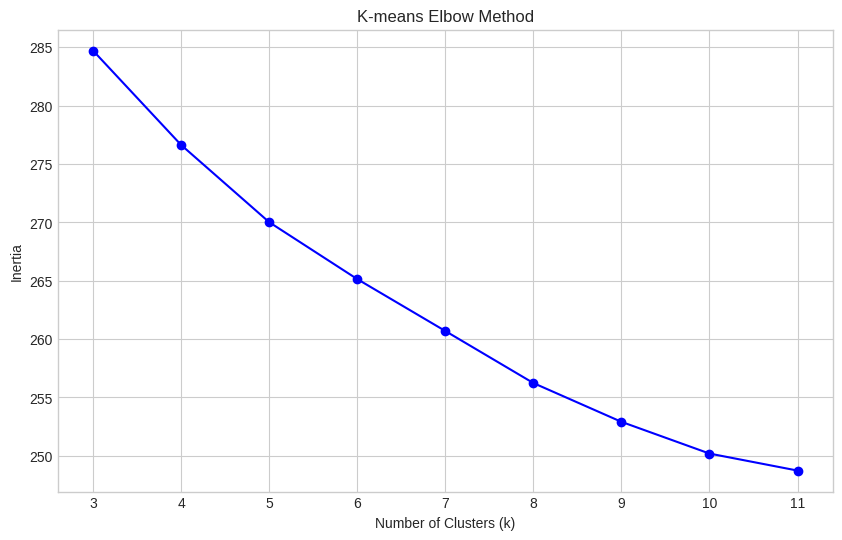

✅ K-means clustering completed with 6 clusters
📊 Cluster sizes:
cluster
0    203
1    132
2    101
3    107
4    178
5    130
Name: count, dtype: int64


In [12]:
# K-means clustering
print("🔄 Performing K-means clustering...")

# Test different numbers of clusters
k_range = range(3, 12)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings_matrix)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.title('K-means Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Choose optimal k (you can adjust this)
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings_matrix)

df['cluster'] = cluster_labels

print(f"✅ K-means clustering completed with {optimal_k} clusters")
print("📊 Cluster sizes:")
print(df['cluster'].value_counts().sort_index())

In [13]:
# Plot clusters on t-SNE
fig = px.scatter(
    df, 
    x='tsne_x', 
    y='tsne_y', 
    color='cluster',
    symbol='source_type',
    hover_data={'title': True, 'year': True, 'journal': True},
    title=f't-SNE Visualization with {optimal_k} Clusters',
    width=900, 
    height=700
)

fig.update_layout(title_x=0.5)
fig.show()

print("📊 Cluster visualization generated")

📊 Cluster visualization generated


## 6. Similarity Analysis. Research landscape map

Samples n random publications (a pairwise similarities for 851 articles would create a 851×851 matrix = 724,201 comparisons)

- Computes cosine similarity between every pair of sampled publications
- Creates a similarity matrix where each cell (i,j) shows how similar publication i is to publication j

1. Diagonal Pattern Bright diagonal line = Each publication is 100% similar to itself (similarity = 1.0)

2. Color Intensity Patterns. Bright/Yellow areas = High similarity (articles are very related). Dark/Purple areas = Low similarity (articles are very different)
3. Block Structures. Bright rectangular blocks = Groups of publications that are all similar to each other. These often correspond to research clusters or topics. Example: All neuroscience papers might form a bright block

The heatmap reveals:

- Topic clusters: Papers on similar subjects cluster together
- Methodological similarity: Papers using similar methods show higher similarity
- Interdisciplinary connections: Moderate similarity between different but related fields
- Outliers: Very dark rows/columns indicate unique or highly specialized papers

In [8]:
# 🎯 INTERACTIVE SIMILARITY HEATMAP WITH PUBLICATION DETAILS (FIXED)

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import numpy as np

def create_interactive_similarity_heatmap(df, embeddings_matrix, sample_size=150):
    """
    Create an interactive similarity heatmap with publication details on hover
    """
    print(f"🔄 Creating interactive similarity heatmap...")
    
    # Sample publications for performance (adjust sample_size as needed)
    sample_size = min(sample_size, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)
    sample_df = df.iloc[sample_indices].copy().reset_index(drop=True)
    sample_embeddings = embeddings_matrix[sample_indices]
    
    print(f"📊 Computing similarities for {sample_size} sample publications...")
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(sample_embeddings)
    
    # Create hover text with publication details
    hover_text = []
    for i in range(len(sample_df)):
        row_hover = []
        for j in range(len(sample_df)):
            # Publication info for both axes
            pub_i = sample_df.iloc[i]
            pub_j = sample_df.iloc[j]
            
            hover_info = (
                f"<b>Similarity: {similarity_matrix[i,j]:.3f}</b><br><br>"
                f"<b>Publication A (Row {i}):</b><br>"
                f"Title: {pub_i['title'][:60]}...<br>"
                f"Year: {pub_i.get('year', 'N/A')}<br>"
                f"Source: {pub_i.get('source_type', 'N/A')}<br>"
                f"Journal: {pub_i.get('journal', 'N/A')[:30]}...<br><br>"
                f"<b>Publication B (Col {j}):</b><br>"
                f"Title: {pub_j['title'][:60]}...<br>"
                f"Year: {pub_j.get('year', 'N/A')}<br>"
                f"Source: {pub_j.get('source_type', 'N/A')}<br>"
                f"Journal: {pub_j.get('journal', 'N/A')[:30]}..."
            )
            row_hover.append(hover_info)
        hover_text.append(row_hover)
    
    # Create axis labels with publication titles (shortened)
    x_labels = [f"{i}: {title[:30]}..." for i, title in enumerate(sample_df['title'])]
    y_labels = [f"{i}: {title[:30]}..." for i, title in enumerate(sample_df['title'])]
    
    # Create the interactive heatmap (FIXED COLORBAR)
    fig = go.Figure(data=go.Heatmap(
        z=similarity_matrix,
        x=x_labels,
        y=y_labels,
        hovertemplate='%{hovertext}<extra></extra>',
        hovertext=hover_text,
        colorscale='Viridis',
        zmid=0.5,  # Center the colorscale
        colorbar=dict(
            title=dict(text="Cosine Similarity", side="right"),  # FIXED: Use title dict
            x=1.02  # Position colorbar to the right
        )
    ))
    
    fig.update_layout(
        title=f'Interactive Cosine Similarity Heatmap ({sample_size} publications)<br><sub>Hover over cells to see publication details</sub>',
        xaxis_title="Publications (Column)",
        yaxis_title="Publications (Row)",
        width=1000,
        height=1000,
        xaxis=dict(tickangle=45, tickfont=dict(size=8)),
        yaxis=dict(tickfont=dict(size=8))
    )
    
    fig.show()
    
    return fig, sample_df, similarity_matrix

# Create the interactive heatmap
print("🎯 Creating interactive similarity visualization...")
interactive_fig, sample_publications, sim_matrix = create_interactive_similarity_heatmap(
    df, embeddings_matrix, sample_size=100  # Adjust size as needed
)

print("✅ Interactive similarity heatmap created!")
print("💡 Hover over any cell to see the publications being compared and their similarity score")

🎯 Creating interactive similarity visualization...
🔄 Creating interactive similarity heatmap...
📊 Computing similarities for 100 sample publications...


✅ Interactive similarity heatmap created!
💡 Hover over any cell to see the publications being compared and their similarity score


In [9]:
# 🎯 ENHANCED INTERACTIVE SIMILARITY HEATMAP WITH MORE FEATURES

def create_enhanced_similarity_heatmap(df, embeddings_matrix, sample_size=100):
    """
    Enhanced interactive similarity heatmap with additional features
    """
    print(f"🔄 Creating enhanced interactive similarity heatmap...")
    
    # Sample publications for performance
    sample_size = min(sample_size, len(df))
    sample_indices = np.random.choice(len(df), sample_size, replace=False)
    sample_df = df.iloc[sample_indices].copy().reset_index(drop=True)
    sample_embeddings = embeddings_matrix[sample_indices]
    
    print(f"📊 Computing similarities for {sample_size} sample publications...")
    
    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(sample_embeddings)
    
    # Create more detailed hover text
    hover_text = []
    for i in range(len(sample_df)):
        row_hover = []
        for j in range(len(sample_df)):
            pub_i = sample_df.iloc[i]
            pub_j = sample_df.iloc[j]
            
            # Add cluster information if available
            cluster_i = pub_i.get('cluster', 'N/A')
            cluster_j = pub_j.get('cluster', 'N/A')
            
            hover_info = (
                f"<b>🎯 Similarity: {similarity_matrix[i,j]:.3f}</b><br>"
                f"<b>📊 Same Cluster: {'✅ Yes' if cluster_i == cluster_j and cluster_i != 'N/A' else '❌ No'}</b><br><br>"
                f"<b>📄 Publication A (Row {i}):</b><br>"
                f"Title: {pub_i['title'][:50]}...<br>"
                f"Year: {pub_i.get('year', 'N/A')} | Source: {pub_i.get('source_type', 'N/A')}<br>"
                f"Journal: {pub_i.get('journal', 'N/A')[:25]}...<br>"
                f"Cluster: {cluster_i}<br><br>"
                f"<b>📄 Publication B (Col {j}):</b><br>"
                f"Title: {pub_j['title'][:50]}...<br>"
                f"Year: {pub_j.get('year', 'N/A')} | Source: {pub_j.get('source_type', 'N/A')}<br>"
                f"Journal: {pub_j.get('journal', 'N/A')[:25]}...<br>"
                f"Cluster: {cluster_j}"
            )
            row_hover.append(hover_info)
        hover_text.append(row_hover)
    
    # Create shortened labels
    x_labels = [f"{i}: {title[:25]}..." for i, title in enumerate(sample_df['title'])]
    y_labels = [f"{i}: {title[:25]}..." for i, title in enumerate(sample_df['title'])]
    
    # Create the heatmap with improved styling
    fig = go.Figure(data=go.Heatmap(
        z=similarity_matrix,
        x=x_labels,
        y=y_labels,
        hovertemplate='%{hovertext}<extra></extra>',
        hovertext=hover_text,
        colorscale='RdYlBu_r',  # Red-Yellow-Blue reversed (high similarity = red/yellow)
        zmin=0,  # Set minimum similarity to 0
        zmax=1,  # Set maximum similarity to 1
        colorbar=dict(
            title=dict(text="Cosine Similarity", side="right"),
            tickmode="linear",
            tick0=0,
            dtick=0.1,
            x=1.02
        )
    ))
    
    fig.update_layout(
        title=dict(
            text=f'🔍 Interactive Publication Similarity Matrix ({sample_size} publications)<br><sub>💡 Hover over cells for detailed comparison | 🟡 High similarity | 🔵 Low similarity</sub>',
            x=0.5,
            font=dict(size=16)
        ),
        xaxis=dict(
            title="Publications (Column)",
            tickangle=45, 
            tickfont=dict(size=8),
            side="bottom"
        ),
        yaxis=dict(
            title="Publications (Row)",
            tickfont=dict(size=8)
        ),
        width=1100,
        height=1000,
        margin=dict(l=100, r=150, t=100, b=150)  # Add margins for labels
    )
    
    return fig, sample_df, similarity_matrix

# Create the enhanced heatmap
print("🎯 Creating enhanced interactive similarity visualization...")
enhanced_fig, sample_pubs, sim_mat = create_enhanced_similarity_heatmap(
    df, embeddings_matrix, sample_size=80  # Smaller sample for better readability
)
enhanced_fig.show()

print("✅ Enhanced interactive similarity heatmap created!")
print("💡 Features:")
print("   • Hover shows detailed publication comparison")
print("   • Color indicates similarity level (red/yellow = high, blue = low)")
print("   • Shows if publications are in the same cluster")
print("   • Improved styling and layout")

🎯 Creating enhanced interactive similarity visualization...
🔄 Creating enhanced interactive similarity heatmap...
📊 Computing similarities for 80 sample publications...


✅ Enhanced interactive similarity heatmap created!
💡 Features:
   • Hover shows detailed publication comparison
   • Color indicates similarity level (red/yellow = high, blue = low)
   • Shows if publications are in the same cluster
   • Improved styling and layout


In [10]:
# Find most similar publications
def find_most_similar_publications(df, embeddings, query_idx, top_k=5):
    """Find most similar publications to a given publication"""
    query_embedding = embeddings[query_idx].reshape(1, -1)
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    
    # Get top k most similar (excluding the query itself)
    top_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    results = []
    for idx in top_indices:
        results.append({
            'index': idx,
            'similarity': similarities[idx],
            'title': df.iloc[idx]['title'],
            'year': df.iloc[idx]['year'],
            'source': df.iloc[idx]['source_type']
        })
    
    return results

# Example: Find similar publications to the first article
query_idx = 0
similar_pubs = find_most_similar_publications(df, embeddings_matrix, query_idx)

print(f"🔍 Publications most similar to: '{df.iloc[query_idx]['title']}'")
print("=" * 80)

for i, pub in enumerate(similar_pubs, 1):
    print(f"{i}. Similarity: {pub['similarity']:.3f} | {pub['source']} | {pub['year']}")
    print(f"   {pub['title'][:80]}...\n")

🔍 Publications most similar to: 'Comprehensive Biomarker Assessment of Pesticide Exposure and Telomere Attrition in Mexican Children from Agricultural Communities.'
1. Similarity: 0.825 | PubMed | 2025
   Evaluating potentially toxic element accumulation in crops near abandoned mine t...

2. Similarity: 0.808 | PubMed | 2025
   Extremely Low-Frequency Magnetic Fields (ELF-MF) and Radiofrequency: Risk of Chi...

3. Similarity: 0.806 | PubMed | 2025
   Association between daily variations in the levels of atmospheric O...

4. Similarity: 0.795 | PubMed | 2024
   Identification of an ArgR-controlled promoter within the outermost region of the...

5. Similarity: 0.794 | PubMed | 2020
   Genotype-Environment Interaction Analysis of NQO1, CYP2E1, and NAT2 Polymorphism...



## 8. Insights & Summary

In [ ]:
# 🔍 ENHANCED CLUSTER ANALYSIS WITH AUTOMATIC CLUSTERING

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def perform_clustering_analysis(df, embeddings_matrix, optimal_k=6):
    """
    Perform clustering if not already done and analyze cluster characteristics
    """
    
    # Check if clustering has already been performed
    if 'cluster' not in df.columns:
        print("⚠️ No clustering found. Performing K-means clustering first...")
        
        # Perform K-means clustering
        print(f"? Performing K-means clustering with k={optimal_k}...")
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings_matrix)
        
        # Add cluster labels to dataframe
        df['cluster'] = cluster_labels
        
        print(f"✅ K-means clustering completed with {optimal_k} clusters")
        print("📊 Cluster sizes:")
        print(df['cluster'].value_counts().sort_index())
        print()
    else:
        print("✅ Clustering already performed")
        print("📊 Cluster sizes:")
        print(df['cluster'].value_counts().sort_index())
        print()
    
    return df

# Ensure clustering is performed
df = perform_clustering_analysis(df, embeddings_matrix, optimal_k=6)

# Now perform the detailed cluster analysis
print("?🔍 DETAILED CLUSTER ANALYSIS")
print("=" * 50)

for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    
    print(f"\n📊 Cluster {cluster_id} ({len(cluster_data)} publications):")
    print(f"   • IFC articles: {len(cluster_data[cluster_data['source_type'] == 'IFC'])}")
    print(f"   • PubMed articles: {len(cluster_data[cluster_data['source_type'] == 'PubMed'])}")
    
    # Year range
    years = cluster_data['year'].dropna()
    if len(years) > 0:
        print(f"   • Year range: {int(years.min())} - {int(years.max())}")
    
    # Top journals
    top_journals = cluster_data['journal'].value_counts().head(3)
    if len(top_journals) > 0:
        print(f"   • Top journals: {', '.join(top_journals.index[:3])}")
    
    # Sample titles
    sample_titles = cluster_data['title'].dropna().head(3)
    print(f"   • Sample titles:")
    for title in sample_titles:
        print(f"     - {title[:60]}...")

print("\n" + "=" * 50)
print("✅ Cluster analysis complete!")

In [ ]:
# Final summary statistics
print("\n🎯 FINAL ANALYSIS SUMMARY")
print("=" * 50)

print(f"📚 Total Publications Analyzed: {len(df)}")
print(f"   • Original IFC publications: {len(df[df['source_type'] == 'IFC'])}")
print(f"   • New PubMed publications: {len(df[df['source_type'] == 'PubMed'])}")

print(f"\n🔬 Embeddings Analysis:")
print(f"   • Embedding model: {MODEL_ID}")
print(f"   • Embedding dimension: {embeddings_matrix.shape[1]}")
print(f"   • Clustering algorithm: K-means with {optimal_k} clusters")

print(f"\n📊 Research Coverage:")
year_range = df['year'].max() - df['year'].min()
print(f"   • Time span: {year_range} years ({df['year'].min()} - {df['year'].max()})")
print(f"   • Unique journals: {df['journal'].nunique()}")
print(f"   • Publications with abstracts: {len(df[df['abstract'].notna()])} ({len(df[df['abstract'].notna()])/len(df)*100:.1f}%)")

print(f"\n🎨 Visualizations Generated:")
print(f"   • t-SNE 2D embedding visualization")
print(f"   • UMAP 2D embedding visualization")
print(f"   • Cluster analysis plots")
print(f"   • Source comparison analysis")
print(f"   • Similarity heatmaps")

print(f"\n💾 Files Saved:")
print(f"   • {embeddings_file}")
print(f"   • {embeddings_meta_file}")

print("\n✅ Embeddings analysis completed successfully!")

## 🚀 Next Steps

After running this analysis, you can:

1. **Explore specific clusters** - Dive deep into publications within each cluster
2. **Topic modeling** - Use the embeddings for more sophisticated topic analysis
3. **Recommendation system** - Build a publication recommendation engine
4. **Time series analysis** - Analyze how research themes evolve over time
5. **Network analysis** - Create citation networks or collaboration graphs
6. **Podcast generation** - Use cluster information to generate themed podcasts

The embeddings and analysis results are saved and can be used in subsequent notebooks!

🔄 EMBEDDING METHODS COMPARISON
✅ Loaded Gemini embeddings: (851, 3072)
✅ Loaded TF-IDF embeddings: (851, 200)
🔄 Using 851 articles for comparison

📊 EMBEDDINGS METADATA:
Gemini API: models/gemini-embedding-001 (3072D)
TF-IDF: TF-IDF + TruncatedSVD (Optimized) (200D)

🧮 Computing dimensionality reductions for both methods...
   Computing t-SNE for Gemini embeddings...


   Computing t-SNE for TF-IDF embeddings...
   Computing UMAP for Gemini embeddings...
   Computing UMAP for Gemini embeddings...


/home/santi/Projects/UBMI-IFC-Podcast/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/santi/Projects/UBMI-IFC-Podcast/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


   Computing UMAP for TF-IDF embeddings...


/home/santi/Projects/UBMI-IFC-Podcast/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Dimensionality reductions complete!

📊 Creating t-SNE comparison visualization...



📊 Creating UMAP comparison visualization...



🧩 Performing clustering comparison...
📊 Cluster agreement: 10.6% of articles assigned to the same cluster
📊 Cluster agreement: 10.6% of articles assigned to the same cluster


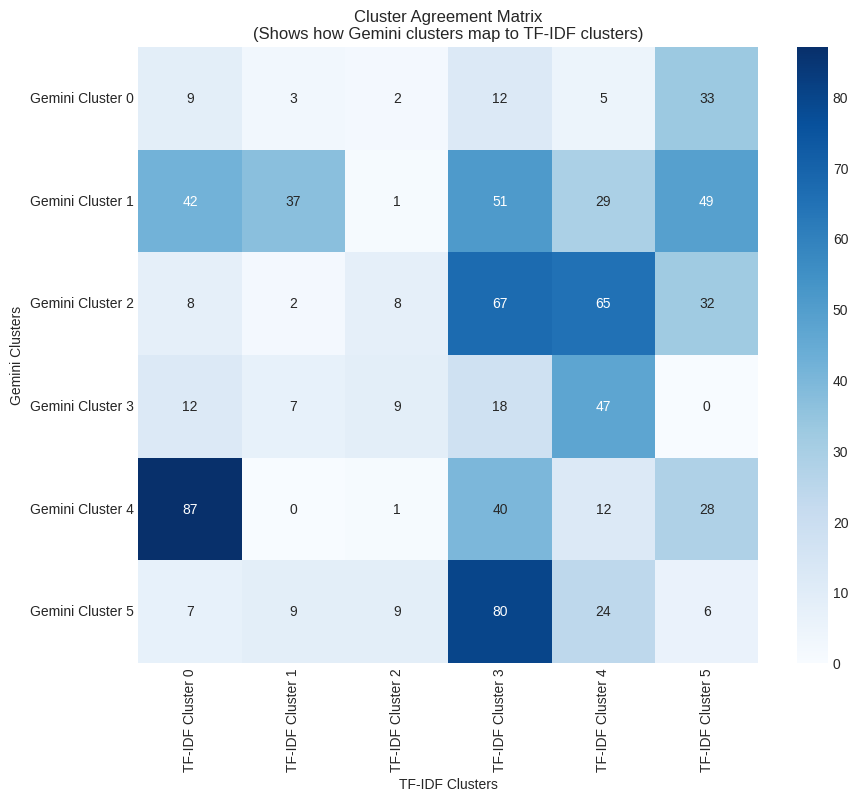


📊 Creating cluster comparison visualization...



📈 CLUSTER COMPARISON ANALYSIS

🏷️  Cluster 0:
   Gemini: 64 articles
   TF-IDF: 165 articles
   Gemini sample: Is Natural IgM a Resilience Factor to Cancer?...
   TF-IDF sample: Transcriptomic shifts in Microtus ochrogaster neurogenic nic...

🏷️  Cluster 1:
   Gemini: 209 articles
   TF-IDF: 58 articles
   Gemini sample: Comprehensive Biomarker Assessment of Pesticide Exposure and...
   TF-IDF sample: Is Natural IgM a Resilience Factor to Cancer?...

🏷️  Cluster 2:
   Gemini: 182 articles
   TF-IDF: 30 articles
   Gemini sample: Multivalvular infective endocarditis due to ...
   TF-IDF sample: Primary colonic lymphoma: clinical dilemmas in diagnosis and...

🏷️  Cluster 3:
   Gemini: 93 articles
   TF-IDF: 268 articles
   Gemini sample: Acute liver injury as a manifestation of granulomatous hepat...
   TF-IDF sample: A National Study of Somatotypes in Mexican Athletes Across 4...

🏷️  Cluster 4:
   Gemini: 168 articles
   TF-IDF: 182 articles
   Gemini sample: Growth hormone reduces re

In [11]:
# 🔄 EMBEDDING METHODS COMPARISON - FIXED
print("🔄 EMBEDDING METHODS COMPARISON")
print("=" * 60)

def load_embeddings_for_comparison(df):
    """Load both Gemini and TF-IDF embeddings for comparison"""
    # Paths to embedding files
    gemini_file = 'data/processed/publication_embeddings.npy'
    gemini_meta_file = 'data/processed/publication_embeddings_meta.json'
    tfidf_file = 'data/processed/tfidf_publication_embeddings.npy'
    tfidf_meta_file = 'data/processed/tfidf_publication_embeddings_meta.json'
    
    # Initialize results
    gemini_embeddings = None
    tfidf_embeddings = None
    gemini_meta = None
    tfidf_meta = None
    
    # Load Gemini embeddings if available
    if os.path.exists(gemini_file) and os.path.exists(gemini_meta_file):
        try:
            gemini_embeddings = np.load(gemini_file)
            with open(gemini_meta_file, 'r') as f:
                gemini_meta = json.load(f)
            print(f"✅ Loaded Gemini embeddings: {gemini_embeddings.shape}")
        except Exception as e:
            print(f"❌ Error loading Gemini embeddings: {e}")
    else:
        print("⚠️ Gemini embeddings not found")
        
    # Load TF-IDF embeddings if available
    if os.path.exists(tfidf_file) and os.path.exists(tfidf_meta_file):
        try:
            tfidf_embeddings = np.load(tfidf_file)
            with open(tfidf_meta_file, 'r') as f:
                tfidf_meta = json.load(f)
            print(f"✅ Loaded TF-IDF embeddings: {tfidf_embeddings.shape}")
        except Exception as e:
            print(f"❌ Error loading TF-IDF embeddings: {e}")
    else:
        print("⚠️ TF-IDF embeddings not found")
    
    # Check if both were loaded correctly
    if gemini_embeddings is not None and tfidf_embeddings is not None:
        # Check sizes - we should use the smaller size to ensure we're comparing the same articles
        min_size = min(len(gemini_embeddings), len(tfidf_embeddings))
        
        # Filter dataframe to match the embeddings
        df_filtered = df.iloc[:min_size].copy()
        
        # Trim embeddings to match
        gemini_embeddings = gemini_embeddings[:min_size]
        tfidf_embeddings = tfidf_embeddings[:min_size]
        
        print(f"🔄 Using {min_size} articles for comparison")
    else:
        # If either is missing, return None
        df_filtered = None
    
    return df_filtered, gemini_embeddings, tfidf_embeddings, gemini_meta, tfidf_meta

# Load both embedding types
df_filtered, gemini_embeddings, tfidf_embeddings, gemini_meta, tfidf_meta = load_embeddings_for_comparison(df)

# Check if we have both embedding types
if df_filtered is None:
    print("❌ Cannot proceed with comparison - missing data")
else:
    # Display embedding metadata
    print("\n📊 EMBEDDINGS METADATA:")
    if gemini_meta:
        print(f"Gemini API: {gemini_meta.get('model', 'Unknown')} ({gemini_embeddings.shape[1]}D)")
    if tfidf_meta:
        print(f"TF-IDF: {tfidf_meta.get('model', 'Unknown')} ({tfidf_embeddings.shape[1]}D)")
    
    # Create both dimensionality reductions
    print("\n🧮 Computing dimensionality reductions for both methods...")
    
    # FIXED: Create separate t-SNE instances for each embedding type with correct parameter
    if gemini_embeddings is not None:
        print("   Computing t-SNE for Gemini embeddings...")
        tsne_gemini = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
        gemini_tsne = tsne_gemini.fit_transform(gemini_embeddings)
        df_filtered['gemini_tsne_x'] = gemini_tsne[:, 0]
        df_filtered['gemini_tsne_y'] = gemini_tsne[:, 1]
    
    if tfidf_embeddings is not None:
        print("   Computing t-SNE for TF-IDF embeddings...")
        tsne_tfidf = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
        tfidf_tsne = tsne_tfidf.fit_transform(tfidf_embeddings)
        df_filtered['tfidf_tsne_x'] = tfidf_tsne[:, 0]
        df_filtered['tfidf_tsne_y'] = tfidf_tsne[:, 1]
    
    # FIXED: Create separate UMAP instances for each embedding type
    if gemini_embeddings is not None:
        print("   Computing UMAP for Gemini embeddings...")
        umap_gemini = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
        gemini_umap = umap_gemini.fit_transform(gemini_embeddings)
        df_filtered['gemini_umap_x'] = gemini_umap[:, 0]
        df_filtered['gemini_umap_y'] = gemini_umap[:, 1]
    
    if tfidf_embeddings is not None:
        print("   Computing UMAP for TF-IDF embeddings...")
        umap_tfidf = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
        tfidf_umap = umap_tfidf.fit_transform(tfidf_embeddings)
        df_filtered['tfidf_umap_x'] = tfidf_umap[:, 0]
        df_filtered['tfidf_umap_y'] = tfidf_umap[:, 1]
        
    print("✅ Dimensionality reductions complete!")

    # Create comparison visualizations
    if gemini_embeddings is not None and tfidf_embeddings is not None:
        # Side-by-side t-SNE visualization
        print("\n📊 Creating t-SNE comparison visualization...")
        fig = make_subplots(rows=1, cols=2, 
                            subplot_titles=("Gemini API Embeddings (t-SNE)", 
                                            "TF-IDF+SVD Embeddings (t-SNE)"))
        
        # Create color mapping for source types
        color_map = {'IFC': 'blue', 'PubMed': 'red'}
        colors_gemini = [color_map[source] for source in df_filtered['source_type']]
        colors_tfidf = [color_map[source] for source in df_filtered['source_type']]
        
        # Gemini t-SNE
        fig.add_trace(
            go.Scatter(
                x=df_filtered['gemini_tsne_x'], 
                y=df_filtered['gemini_tsne_y'],
                mode='markers',
                marker=dict(
                    size=7,
                    color=colors_gemini,
                    opacity=0.7
                ),
                text=[f"Title: {title[:50]}...<br>Year: {year}<br>Source: {source}" 
                      for title, year, source in zip(df_filtered['title'], 
                                                     df_filtered['year'], 
                                                     df_filtered['source_type'])],
                hovertemplate='%{text}<extra></extra>',
                name='Gemini',
                showlegend=False
            ),
            row=1, col=1
        )
        
        # TF-IDF t-SNE
        fig.add_trace(
            go.Scatter(
                x=df_filtered['tfidf_tsne_x'], 
                y=df_filtered['tfidf_tsne_y'],
                mode='markers',
                marker=dict(
                    size=7,
                    color=colors_tfidf,
                    opacity=0.7
                ),
                text=[f"Title: {title[:50]}...<br>Year: {year}<br>Source: {source}" 
                      for title, year, source in zip(df_filtered['title'], 
                                                     df_filtered['year'], 
                                                     df_filtered['source_type'])],
                hovertemplate='%{text}<extra></extra>',
                name='TF-IDF',
                showlegend=False
            ),
            row=1, col=2
        )
        
        fig.update_layout(
            title_text="🔍 Comparison of Embedding Methods (t-SNE)<br><sub>Blue: IFC Articles | Red: PubMed Articles</sub>",
            height=600, 
            width=1200
        )
        
        fig.show()
        
        # Side-by-side UMAP visualization
        print("\n📊 Creating UMAP comparison visualization...")
        fig = make_subplots(rows=1, cols=2, 
                            subplot_titles=("Gemini API Embeddings (UMAP)", 
                                            "TF-IDF+SVD Embeddings (UMAP)"))
        
        # Gemini UMAP
        fig.add_trace(
            go.Scatter(
                x=df_filtered['gemini_umap_x'], 
                y=df_filtered['gemini_umap_y'],
                mode='markers',
                marker=dict(
                    size=7,
                    color=colors_gemini,
                    opacity=0.7
                ),
                text=[f"Title: {title[:50]}...<br>Year: {year}<br>Source: {source}" 
                      for title, year, source in zip(df_filtered['title'], 
                                                     df_filtered['year'], 
                                                     df_filtered['source_type'])],
                hovertemplate='%{text}<extra></extra>',
                name='Gemini',
                showlegend=False
            ),
            row=1, col=1
        )
        
        # TF-IDF UMAP
        fig.add_trace(
            go.Scatter(
                x=df_filtered['tfidf_umap_x'], 
                y=df_filtered['tfidf_umap_y'],
                mode='markers',
                marker=dict(
                    size=7,
                    color=colors_tfidf,
                    opacity=0.7
                ),
                text=[f"Title: {title[:50]}...<br>Year: {year}<br>Source: {source}" 
                      for title, year, source in zip(df_filtered['title'], 
                                                     df_filtered['year'], 
                                                     df_filtered['source_type'])],
                hovertemplate='%{text}<extra></extra>',
                name='TF-IDF',
                showlegend=False
            ),
            row=1, col=2
        )
        
        fig.update_layout(
            title_text="🔍 Comparison of Embedding Methods (UMAP)<br><sub>Blue: IFC Articles | Red: PubMed Articles</sub>",
            height=600, 
            width=1200
        )
        
        fig.show()
        
        # Compare clustering results
        print("\n🧩 Performing clustering comparison...")
        optimal_k = 6
        
        # Perform k-means clustering on both embedding types
        if gemini_embeddings is not None:
            kmeans_gemini = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
            df_filtered['gemini_cluster'] = kmeans_gemini.fit_predict(gemini_embeddings)
            
        if tfidf_embeddings is not None:
            kmeans_tfidf = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
            df_filtered['tfidf_cluster'] = kmeans_tfidf.fit_predict(tfidf_embeddings)
        
        # Calculate cluster agreement
        agreement = sum(df_filtered['gemini_cluster'] == df_filtered['tfidf_cluster']) / len(df_filtered)
        print(f"📊 Cluster agreement: {agreement:.1%} of articles assigned to the same cluster")
        
        # Create confusion matrix for cluster comparison
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        
        conf_matrix = confusion_matrix(df_filtered['gemini_cluster'], df_filtered['tfidf_cluster'])
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[f'TF-IDF Cluster {i}' for i in range(optimal_k)],
                    yticklabels=[f'Gemini Cluster {i}' for i in range(optimal_k)])
        plt.title('Cluster Agreement Matrix\n(Shows how Gemini clusters map to TF-IDF clusters)')
        plt.ylabel('Gemini Clusters')
        plt.xlabel('TF-IDF Clusters')
        plt.show()
        
        # Visualize clusters side by side
        print("\n📊 Creating cluster comparison visualization...")
        fig = make_subplots(rows=1, cols=2, 
                           subplot_titles=("Gemini API Clusters", 
                                          "TF-IDF+SVD Clusters"))
        
        # Gemini clustering
        fig.add_trace(
            go.Scatter(
                x=df_filtered['gemini_tsne_x'], 
                y=df_filtered['gemini_tsne_y'],
                mode='markers',
                marker=dict(
                    size=7,
                    color=df_filtered['gemini_cluster'],
                    colorscale='Viridis',
                    opacity=0.7,
                    showscale=False
                ),
                text=[f"Title: {title[:50]}...<br>Cluster: {cluster}<br>Source: {source}" 
                      for title, cluster, source in zip(df_filtered['title'], 
                                                        df_filtered['gemini_cluster'],
                                                        df_filtered['source_type'])],
                hovertemplate='%{text}<extra></extra>',
                name='Gemini Clusters',
                showlegend=False
            ),
            row=1, col=1
        )
        
        # TF-IDF clustering
        fig.add_trace(
            go.Scatter(
                x=df_filtered['tfidf_tsne_x'], 
                y=df_filtered['tfidf_tsne_y'],
                mode='markers',
                marker=dict(
                    size=7,
                    color=df_filtered['tfidf_cluster'],
                    colorscale='Viridis',
                    opacity=0.7,
                    showscale=True
                ),
                text=[f"Title: {title[:50]}...<br>Cluster: {cluster}<br>Source: {source}" 
                      for title, cluster, source in zip(df_filtered['title'], 
                                                        df_filtered['tfidf_cluster'],
                                                        df_filtered['source_type'])],
                hovertemplate='%{text}<extra></extra>',
                name='TF-IDF Clusters',
                showlegend=False
            ),
            row=1, col=2
        )
        
        fig.update_layout(
            title_text=f"🎯 Comparison of Clustering Results (k={optimal_k})<br><sub>Agreement: {agreement:.1%} of articles in same relative clusters</sub>",
            height=600, 
            width=1200
        )
        
        fig.show()
        
        # Analyze cluster characteristics
        print(f"\n📈 CLUSTER COMPARISON ANALYSIS")
        print("=" * 50)
        
        for i in range(optimal_k):
            gemini_cluster_articles = df_filtered[df_filtered['gemini_cluster'] == i]
            tfidf_cluster_articles = df_filtered[df_filtered['tfidf_cluster'] == i]
            
            print(f"\n🏷️  Cluster {i}:")
            print(f"   Gemini: {len(gemini_cluster_articles)} articles")
            print(f"   TF-IDF: {len(tfidf_cluster_articles)} articles")
            
            # Show sample titles from each method's cluster
            if len(gemini_cluster_articles) > 0:
                print(f"   Gemini sample: {gemini_cluster_articles.iloc[0]['title'][:60]}...")
            if len(tfidf_cluster_articles) > 0:
                print(f"   TF-IDF sample: {tfidf_cluster_articles.iloc[0]['title'][:60]}...")
        
        print("\n✅ Embedding comparison complete!")
        print(f"📊 Summary:")
        print(f"   • Gemini embeddings: {gemini_embeddings.shape[1]}D high-quality semantic vectors")
        print(f"   • TF-IDF embeddings: {tfidf_embeddings.shape[1]}D fast local vectors")
        print(f"   • Cluster agreement: {agreement:.1%}")
        
    else:
        print("⚠️ Cannot create comparison visualizations - missing one or both embedding types")